# 07 - Au-delà des Confondants

## Bons Contrôles

Nous avons vu comment l'ajout de contrôles supplémentaires à notre modèle de régression peut aider à identifier un effet causal. Si le contrôle est un facteur de confusion, l'ajouter au modèle n'est pas seulement souhaitable, mais nécessaire. Lorsqu'une personne non avertie voit cela, une réponse naturelle est d'inclure tout ce qu'elle peut mesurer dans le modèle. Dans le monde actuel des mégadonnées, cela pourrait facilement dépasser 1000 variables. Il s'avère que cela n'est pas seulement inutile, mais peut être préjudiciable à l'identification causale. Nous allons maintenant nous concentrer sur les contrôles qui ne sont pas des facteurs de confusion. D'abord, examinons les bons contrôles. Ensuite, nous nous pencherons sur les contrôles nuisibles.

Comme exemple motivant, supposons que vous êtes un data scientist dans l'équipe de recouvrement d'une fintech. Votre prochaine tâche est de déterminer l'impact de l'envoi d'un e-mail demandant aux gens de négocier leur dette. Votre variable de réponse est le montant des paiements des clients en retard.

Pour répondre à cette question, votre équipe sélectionne 5000 clients aléatoires parmi vos clients en retard pour effectuer un test aléatoire. Pour chaque client, vous lancez une pièce : si c'est pile, le client reçoit l'e-mail ; sinon, il est laissé en tant que contrôle. Avec ce test, vous espérez découvrir combien d'argent supplémentaire l'e-mail génère.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


Étant donné que les données sont aléatoires, vous savez qu'une simple différence de moyennes estime l'effet moyen du traitement (ATE). En d'autres termes, rien ne peut avoir causé le traitement à part la randomisation, donc les résultats potentiels sont indépendants du traitement : $(Y_0, Y_1)\perp T$.

$$
ATE = E[Y|T=1] - E[Y|T=0]
$$

Comme vous êtes intelligent et souhaitez placer un intervalle de confiance autour de votre estimation, vous utilisez une régression linéaire.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


Malheureusement, l'ATE estimé est de -0.62, ce qui est assez étrange. Comment l'envoi d'un e-mail peut-il faire en sorte que les clients en retard paient moins que la moyenne ? Cependant, la valeur-p est si élevée que cela ne signifie probablement rien. Que devriez-vous faire maintenant ? Retourner auprès de votre équipe en disant que le test est inconclusif et que vous avez besoin de plus de données ? Pas si vite.

Remarquez que vos données ont d'autres colonnes intéressantes. Par exemple, `credit_limit` représente la ligne de crédit du client avant qu'il ou elle ne soit en retard. `risk_score` correspond au risque estimé du client avant l'envoi de l'e-mail. Il est logique de penser que la limite de crédit et le risque sont probablement de très bons prédicteurs des paiements. Mais comment cela peut-il être utile ?

Tout d'abord, comprenons pourquoi nous pouvons échouer à trouver une signification statistique dans un traitement même lorsqu'il existe. Il se peut que, comme dans ce cas, le traitement ait très peu d'impact sur le résultat. Si vous y réfléchissez, ce qui pousse les gens à payer leur dette est, en grande partie, des facteurs échappant au contrôle du département de recouvrement. Les gens paient leur dette parce qu'ils trouvent un nouvel emploi, gèrent leurs finances, leurs revenus, etc. En termes statistiques, nous pouvons dire que **la variabilité des paiements est beaucoup plus expliquée par d'autres facteurs que par l'e-mail**.

Pour en avoir une compréhension visuelle, nous pouvons tracer les paiements en fonction de la variable de traitement e-mail. J'ai également tracé la ligne ajustée du modèle ci-dessus en rouge. Pour aider à la visualisation, j'ai ajouté un peu de bruit à la variable e-mail afin qu'elle ne soit pas écrasée à zéro ou un.

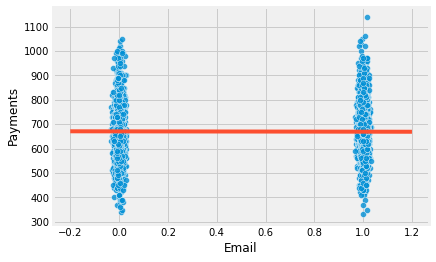

In [4]:
sns.scatterplot(x="email", y="payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

Nous pouvons voir à quel point les paiements varient énormément dans un seul groupe de traitement. Visuellement, cela semble aller d'un peu moins de 400 à 1000 dans les deux groupes. Si l'impact de l'e-mail est de l'ordre de 5,00 ou 10,00 R$, il n'est pas étonnant qu'il soit difficile de le trouver au milieu de toute cette variabilité.

Heureusement, la régression peut nous aider à réduire cette variabilité. L'astuce consiste à utiliser des contrôles supplémentaires. **Si une variable est un bon prédicteur du résultat, elle expliquera une grande partie de sa variance**. Si le risque et la limite de crédit sont de bons prédicteurs du paiement, nous pouvons les contrôler pour faciliter la détection de l'impact de l'e-mail sur les paiements. Si nous nous rappelons comment fonctionne la régression, cela a une explication intuitive. Ajouter des variables supplémentaires à une régression signifie les maintenir constantes tout en examinant le traitement. Donc, le raisonnement est le suivant : si nous examinons des niveaux similaires de risque et de limite de crédit, la variance de la variable de réponse `paiements` devrait être plus faible. Autrement dit, si le risque et la ligne de crédit prédisent très bien les paiements, les clients ayant un risque et une ligne de crédit similaires devraient également avoir des niveaux de paiement similaires, donc avec moins de variance.

![img](./data/img/beyond-conf/y-pred.png)

Pour démontrer cela, utilisons la méthode de la décomposition partielle pour diviser la régression en 2 étapes. Premièrement, nous régressons le traitement, l'e-mail, et le résultat, les paiements, sur les contrôles supplémentaires, la limite de crédit et le score de risque. Deuxièmement, nous régressons le résidu du traitement sur les résidus des paiements, tous deux obtenus à l'étape 1. (Ceci est purement pédagogique, en pratique, vous n'aurez pas besoin de passer par toutes ces étapes).

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

Cela réduit la variance de la variable dépendante. En régressant les paiements sur la limite de crédit et le risque et en obtenant les résidus pour ce modèle, nous créons une nouvelle variable dépendante avec beaucoup moins de variabilité que l'originale. Le dernier modèle révèle également l'`ATE` avec une estimation valide de l'erreur standard.

Par curiosité, nous pouvons également vérifier que le modèle qui prédit le traitement ne devrait pas être capable de réduire sa variance. C'est parce que l'e-mail est, par conception, aléatoire, donc rien ne peut le prédire.

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466207
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.71e-13,1.063,-3.49e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


Remarquez comment la variance des paiements est passée de 10807 à 5652. Nous l'avons réduite de presque moitié une fois que nous avons contrôlé le risque et les limites de crédit. Notez également que nous n'avons pas réussi à réduire la variabilité du traitement par e-mail. Cela a du sens, puisque le risque et la ligne de crédit ne prédisent pas l'e-mail (rien ne le fait, par définition de l'aléatoire).

Maintenant, nous voyons quelque chose de beaucoup plus raisonnable. Cette nouvelle estimation nous indique que nous devrions nous attendre à ce que les clients qui ont reçu l'e-mail paient, en moyenne, 4.4 reais de plus que ceux du groupe de contrôle. Cette estimation est désormais statistiquement différente de zéro. Nous pouvons également visualiser comment la variance est maintenant plus faible au sein de chaque groupe de contrôle.

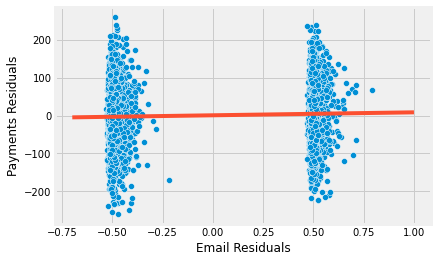

In [7]:
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

Comme je l'ai dit, nous avons fait cela pour des raisons pédagogiques. En pratique, vous pouvez simplement ajouter les contrôles au modèle de régression avec le traitement et les estimations seront exactement les mêmes.

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


Pour conclure, chaque fois que nous avons un contrôle qui est un bon prédicteur du résultat, même s'il n'est pas un facteur de confusion, l'ajouter à notre modèle est une bonne idée. Cela aide à réduire la variance de nos estimations de l'effet du traitement. Voici une illustration de ce à quoi ressemble cette situation avec des graphes causaux.

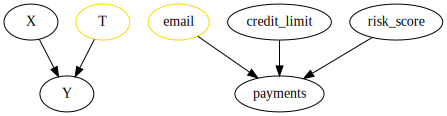

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Contrôles Plutôt Nuisibles

Comme deuxième exemple motivant, considérons un scénario de test de médicament avec 2 hôpitaux. Les deux mènent des essais randomisés sur un nouveau médicament pour traiter une certaine maladie. Le résultat d'intérêt est le nombre de jours d'hospitalisation. Si le traitement est efficace, il réduira le nombre de jours que le patient passe à l'hôpital. Pour l'un des hôpitaux, la politique concernant le traitement aléatoire est de l'administrer à 90 % de ses patients tandis que 10 % reçoivent un placebo. L'autre hôpital a une politique différente : il donne le médicament à un 10 % aléatoire de ses patients et 90 % reçoivent un placebo. On vous dit également que l'hôpital qui donne 90 % du véritable médicament et 10 % de placebo reçoit généralement des cas plus graves de la maladie à traiter.

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


Comme vous traitez des données randomisées, votre premier instinct est de simplement effectuer une régression du résultat sur le traitement.

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


Mais vous obtenez des résultats contre-intuitifs. Comment le traitement peut-il augmenter le nombre de jours d'hospitalisation ? La réponse réside dans le fait que nous menons deux expériences différentes. La gravité est positivement liée à un plus grand nombre de jours à l'hôpital et, comme l'hôpital avec les cas les plus graves administre également plus de médicaments, le médicament devient positivement corrélé à un plus grand nombre de jours à l'hôpital. Lorsque nous regardons les deux hôpitaux ensemble, nous avons $E[Y_0|T=0]<E[Y_0|T=1]$, c'est-à-dire que le résultat potentiel des non-traités est, en moyenne, inférieur à celui des traités parce qu'il y a plus de non-traités dans l'hôpital avec les cas les moins graves. En d'autres termes, la gravité agit comme un facteur de confusion, déterminant l'hôpital où va le patient et, par conséquent, la probabilité de recevoir le médicament.

Il y a deux façons de résoudre ce problème. La première, qui va à l'encontre de l'utilisation des données des deux hôpitaux, est de simplement examiner l'ATE dans chaque hôpital individuellement.

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


Dans ce cas, nous obtenons un résultat intuitif de l'ATE. Il semble maintenant que le médicament réduit en effet le nombre de jours d'hospitalisation. Cependant, comme nous examinons chaque hôpital individuellement, il n'y a pas assez de points de données. En conséquence, nous ne pouvons pas obtenir de résultats statistiquement significatifs.

L'autre approche, qui exploite la puissance de la régression, consiste à contrôler la gravité en l'incluant dans le modèle.

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


La question qui se pose ensuite est de savoir si nous devons également inclure l'hôpital dans le modèle. Après tout, nous savons que les hôpitaux influencent le traitement, n'est-ce pas ? C'est vrai, mais une fois que nous avons contrôlé la gravité, l'hôpital n'est plus corrélé avec le nombre de jours d'hospitalisation, qui est le résultat. Et nous savons que pour être un facteur de confusion, une variable doit à la fois influencer le traitement et le résultat. Dans ce cas, nous avons une variable qui ne cause que le traitement.

Mais peut-être que le contrôler réduit la variance, non ? Eh bien, encore une fois, ce n'est pas vrai. Pour qu'un contrôle réduise la variance, il doit être un bon prédicteur du résultat, et non du traitement, ce qui est le cas ici.

Cependant, nous pourrions vouloir le contrôler, n'est-ce pas ? Cela ne peut pas faire de mal... Ou bien ?

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


Surprenamment, cela peut faire du mal !

![img](./data/img/beyond-conf/shocked.png)

Ajouter l'hôpital en plus de la gravité comme contrôle a introduit PLUS de variance dans notre estimateur d'ATE. Comment cela se peut-il ? La réponse réside dans la formule de l'erreur standard du coefficient de régression.

$$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$$

$$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$$

D'après cette formule, nous pouvons voir que l'erreur standard est inversement proportionnelle à la variance de la variable $X$. Cela signifie que, si $X$ ne change pas beaucoup, il sera difficile d'estimer son effet sur le résultat. Cela a également du sens intuitivement. Prenons un exemple extrême et supposons que vous souhaitiez estimer l'effet d'un médicament, vous effectuez donc un test avec 10000 individus mais un seul d'entre eux reçoit le traitement. Cela rendra la recherche de l'ATE très difficile, nous devrons comparer un individu unique avec tous les autres. Une autre façon de dire cela est que nous avons besoin de beaucoup de variabilité dans le traitement pour faciliter la recherche de son impact.

Quant à la raison pour laquelle inclure les hôpitaux dans le modèle augmente l'erreur de notre estimation, c'est parce que c'est un bon prédicteur du traitement et non du résultat (une fois que nous contrôlons la gravité). Ainsi, en prédisant le traitement, il réduit effectivement sa variance ! Encore une fois, nous pouvons recourir à la partition de notre régression en 2 étapes pour voir cela.

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.817e-14,0.827,3.41e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.05752909187211906


Mais ne me croyez pas sur parole ! Vous pouvez vérifier que la formule de l’erreur standard ci-dessus est vraie :

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.446973767486901


Donc, la conclusion est que nous devrions ajouter des contrôles qui sont à la fois corrélés avec le traitement et le résultat (facteur de confusion), comme la gravité dans le modèle ci-dessus. Nous devrions également ajouter des contrôles qui sont de bons prédicteurs du résultat, même s'ils ne sont pas des facteurs de confusion, car ils réduisent la variance de nos estimations. Cependant, nous ne devrions **PAS** ajouter des contrôles qui sont simplement de bons prédicteurs du traitement, car ils augmenteront la variance de nos estimations.

Voici une illustration avec des graphes causaux.

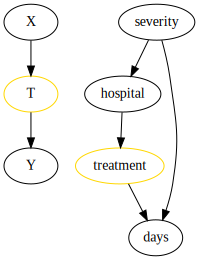

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## Mauvais Contrôles - Biais de Sélection

Revenons à l'exemple de l'e-mail de recouvrement. Rappelez-vous que l'e-mail a été attribué aléatoirement aux clients. Nous avons déjà expliqué ce que sont `credit_limit` et `risk_score`. Maintenant, regardons les variables restantes. `opened` est une variable dummy indiquant si le client a ouvert l'e-mail ou non. `agreement` est une autre variable dummy indiquant si les clients ont contacté le service de recouvrement pour négocier leur dette après avoir reçu l'e-mail. Lequel des modèles suivants pensez-vous être le plus approprié ? Le premier est un modèle avec la variable de traitement plus `credit_limit` et `risk_score`; le second ajoute les variables dummies `opened` et `agreement`.

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


Bien que le premier modèle trouve des résultats statistiquement significatifs pour l'e-mail, le second ne le fait pas. Mais peut-être que le second modèle est le bon et qu'il n'y a aucun effet pour l'e-mail. Après tout, ce modèle contrôle plus de facteurs, donc il devrait être plus robuste, n'est-ce pas ? À ce stade, vous savez probablement que ce n'est pas le cas. Ce qui reste à comprendre, c'est pourquoi.

Nous savons que nous devons ajouter des variables de confusion. Des variables qui causent à la fois le traitement et le résultat. Nous savons aussi qu'il est judicieux d'ajouter des contrôles qui prédisent très bien le résultat. Ce n'est pas obligatoire, mais c'est un plus. Nous savons également qu'il est déconseillé d'ajouter des contrôles qui ne prédisent que le traitement. Encore une fois, ce n'est pas un péché mortel, mais il vaut mieux l'éviter. Alors, quel type de contrôles sont `opened` et `agreement` ? Il s'avère qu'ils ne sont ni l'un ni l'autre.

Si vous y réfléchissez, `opened` et `agreement` sont sûrement corrélés avec l'e-mail. Après tout, vous ne pouvez pas ouvrir l'e-mail si vous ne l'avez pas reçu et nous avons également dit que l'accord ne considère que la renégociation qui a eu lieu après l'envoi de l'e-mail. Mais **ils ne causent pas l'e-mail ! Au lieu de cela, ils sont causés par lui !**

Chaque fois que j'ai besoin de comprendre de quel type de variables je traite, j'aime toujours penser à leur graphe causal. Faisons cela ici.

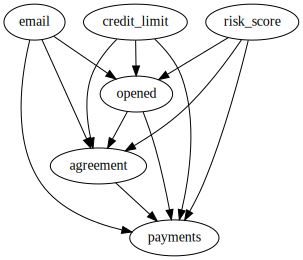

In [22]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

Nous savons que rien ne cause l'e-mail, car il est aléatoire par conception. Et nous savons (ou du moins nous avons de bonnes raisons de croire) que la limite de crédit et le risque causent les paiements. Nous pensons également que l'e-mail cause les paiements. En ce qui concerne `opened`, nous pensons que cela cause les paiements. Intuitivement, les personnes qui ont ouvert l'e-mail de recouvrement sont plus enclines à négocier et à payer leur dette. Nous pensons également que `opened` cause les accords pour les mêmes raisons qu'il cause les paiements. De plus, nous savons que `opened` est causé par l'e-mail et nous avons des raisons de croire que les personnes avec différents niveaux de risque et de limite de crédit ont des taux d'ouverture différents pour les e-mails, donc la limite de crédit et le risque causent également l'ouverture des e-mails. En ce qui concerne l'accord, nous pensons également qu'il est causé par `opened`. Si nous pensons à la variable de réponse des paiements, nous pouvons la considérer comme le résultat d'un entonnoir :

$$
email -> opened -> agreement -> payment 
$$

Nous pensons également que différents niveaux de risque et de limite de crédit ont différentes propensions à conclure un accord, donc nous les marquerons également comme causant des accords. En ce qui concerne l'e-mail et l'accord, nous pourrions argumenter que certaines personnes lisent simplement l'objet de l'e-mail, ce qui les rend plus susceptibles de conclure un accord. Le point est que l'e-mail pourrait également causer un accord sans passer par `opened`.

Ce que nous remarquons avec ce graphe, c'est que `opened` et `agreement` sont tous deux sur le chemin causal de l'e-mail aux paiements. Donc, si nous les contrôlons avec une régression, nous dirions "c'est l'effet de l'e-mail tout en maintenant `opened` et `agreement` fixes". Cependant, les deux font partie de l'effet causal de l'e-mail, donc nous ne voulons pas les maintenir fixes. Au contraire, nous pourrions dire que l'e-mail augmente les paiements précisément parce qu'il augmente le taux d'accord. Si nous fixons ces variables, nous supprimons une partie du véritable effet de la variable e-mail.

Avec la notation des résultats potentiels, nous pouvons dire que, grâce à la randomisation $E[Y_0|T=0] = E[Y_0|T=1]$. Cependant, même avec la randomisation, lorsque nous contrôlons l'accord, traitement et contrôle ne sont plus comparables. En fait, avec un peu de réflexion intuitive, nous pouvons même deviner comment ils sont différents :

$$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$$

$$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$$

La première équation explicite que nous pensons que ceux sans l'e-mail et sans accord sont meilleurs que ceux avec l'e-mail et sans accord. Cela est dû au fait que, si le traitement a un effet positif, ceux qui n'ont pas fait d'accord **même après avoir reçu l'e-mail** sont probablement pires en termes de paiements par rapport à ceux qui n'ont également pas fait l'accord mais n'ont pas non plus reçu l'incitation supplémentaire de l'e-mail. En ce qui concerne la deuxième équation, ceux qui ont conclu l'accord même sans avoir reçu le traitement sont probablement meilleurs que ceux qui ont conclu l'accord mais ont eu l'incitation supplémentaire de l'e-mail.

Cela peut être très déroutant la première fois que vous le lisez (ça l'a été pour moi), mais assurez-vous de le comprendre. Relisez-le si nécessaire. Ensuite, un raisonnement similaire peut être fait avec la variable `opened`. Essayez de le faire vous-même.

Ce genre de biais est si répandu qu'il a son propre nom. Alors que la confusion est le biais dû au manque de contrôle d'une cause commune, **le biais de sélection se produit lorsque nous contrôlons un effet commun ou une variable intermédiaire entre la cause et l'effet.** En règle générale, incluez toujours les facteurs de confusion et les variables qui sont de bons prédicteurs de $Y$ dans votre modèle. Excluez toujours les variables qui sont de bons prédicteurs seulement de $T$, les médiateurs entre le traitement et le résultat ou les effets communs du traitement et du résultat.

![img](./data/img/beyond-conf/selection.png)

Le biais de sélection est si répandu que même la randomisation ne peut pas le corriger. De plus, il est souvent introduit par des personnes mal avisées, même dans des données randomisées ! Repérer et éviter le biais de sélection demande plus de pratique que de compétences. Souvent, ils apparaissent sous une idée soi-disant ingénieuse, ce qui les rend encore plus difficiles à découvrir. Voici quelques exemples de biais de sélection que j'ai rencontrés :

1. Ajouter une variable dummy pour le paiement de la totalité de la dette lorsqu'on essaie d'estimer l'effet d'une stratégie de recouvrement sur les paiements.
2. Contrôler pour les emplois cadre vs non-cadre lors de l'estimation de l'effet de la scolarité sur les revenus.
3. Contrôler la conversion lors de l'estimation de l'impact des taux d'intérêt sur la durée des prêts.
4. Contrôler le bonheur conjugal lors de l'estimation de l'impact des enfants sur les relations extraconjugales.
5. Diviser le modèle de paiement E[Payments] en un modèle binaire qui prédit si un paiement se produira et un autre modèle qui prédit combien de paiements se produiront étant donné qu'il y en aura : E[Payments|Payments>0]*P(Payments>0).

Ce qui est remarquable dans toutes ces idées, c'est leur apparence raisonnable. Le biais de sélection semble souvent raisonnable. Considérez cela comme un avertissement. En fait, je suis moi-même tombé dans ces pièges de nombreuses fois avant de comprendre à quel point ils étaient mauvais. Un en particulier, le dernier, mérite une explication plus approfondie parce qu'il semble si astucieux et piège beaucoup de data scientists. Il est si répandu qu'il a son propre nom : **The Bad COP** !

### Bad COP

La situation est la suivante. Vous avez une variable continue que vous souhaitez prédire, mais sa distribution est surreprésentée à zéro. Par exemple, si vous souhaitez modéliser les dépenses des consommateurs, vous aurez quelque chose comme une distribution gamma, mais avec beaucoup de zéros.

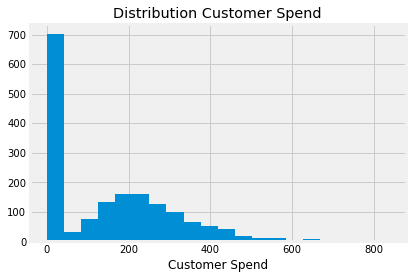

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

Lorsqu'un data scientist voit cela, la première idée qui lui vient à l'esprit est de diviser la modélisation en deux étapes. La première est la participation, c'est-à-dire la probabilité que $Y > 0$. Dans notre exemple de dépenses, cela consisterait à modéliser si le client a décidé de dépenser ou non. La deuxième partie modélise $Y$ pour ceux qui ont décidé de participer. C'est l'effet Conditionnel-sur-Positifs (COP - *conditional-on-positive* en anglais). Dans notre cas, cela représenterait combien le client dépense après avoir décidé de dépenser quelque chose. Si nous voulons estimer l'effet du traitement $T$ sur les dépenses, cela ressemblerait à ceci :

$$
E[Y|T] = E[Y|Y>0, T]P(Y>0|T)
$$

Il n'y a rien de mal avec le modèle de participation $P(Y_i>0|T_i)$. En fait, si $T$ est attribué aléatoirement, il capturera l'augmentation de la probabilité de dépenser due au traitement. De plus, il n'y a rien de mal avec la décomposition ci-dessus. C'est mathématiquement vrai, selon la loi des probabilités totales.

Le problème réside dans l'estimation de la partie COP. **Elle sera biaisée même sous assignation aléatoire**. Intuitivement, il n'est pas fou de penser que certaines unités sont des zéros uniquement parce qu'elles n'ont pas reçu le traitement. Le traitement les empêcherait d'être des zéros. D'autre part, certaines unités ne sont jamais des zéros. Le traitement pourrait augmenter leur résultat, mais même sans lui, elles ne seraient pas des zéros. Maintenant, le point clé est de comprendre que ces deux types d'unités ne sont pas comparables. Ceux qui ne sont jamais des zéros ont un $Y_0$ élevé par rapport à ceux qui sont des zéros s'ils n'ont pas reçu le traitement. En fait, pour ces derniers, $Y_0=0$.

Sachant cela, si nous éliminons les zéros, nous garderons les jamais-zéros dans les groupes traité et contrôle. Mais nous éliminerions du groupe contrôle ceux qui passent de zéro à non-zéro avec le traitement. Cela rendrait le traitement et le contrôle non comparables, car le contrôle ne contiendrait que ceux qui ne sont jamais des zéros et qui ont un $Y_0$ plus élevé, tandis que le groupe traité contiendrait les deux types d'unités.

Maintenant que nous avons une compréhension intuitive du problème, examinons-le d'un point de vue mathématique. Pour le voir, décomposons l'effet du traitement. Sous assignation aléatoire, il est égal à la différence de moyennes

$$
\begin{align*}
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Effet \ de \ Participation} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{Effet \ COP} * P(Y>0|T=0)
\end{align*}
$$

Où la dernière égalité provient de l'ajout et de la soustraction de $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$ et du réarrangement des termes. Cela signifie que la différence des moyennes est composée de deux parties : d'abord, c'est la différence de probabilité que le résultat $y$ soit positif. C'est ce qu'on appelle l'effet de participation car il mesure l'augmentation de la probabilité que les clients participent aux dépenses. Ensuite, c'est la différence du résultat conditionné à la participation, l'effet COP. Jusqu'ici, tout va bien. Il n'y a rien de mal à cela. C'est une vérité mathématique. Le problème vient quand nous essayons d'estimer chaque partie séparément.

Cela devient plus évident si nous analysons l'effet COP encore plus en détail.

$$
\begin{align*}
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Effet \ Causal} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Biais \ de \ Sélection}
\end{align*}
$$

où la deuxième égalité vient après avoir ajouté et soustrait $E[Y_{i0}|Y_{i1}>0]$. Lorsque nous décomposons l'effet COP, nous obtenons d'abord l'effet causal sur la sous-population des participants. Dans notre exemple, ce serait l'effet causal sur ceux qui décident de dépenser quelque chose. Ensuite, nous obtenons un terme de biais qui est la différence de $Y_0$ pour ceux qui décident de participer lorsqu'ils sont assignés au traitement ($E[Y_{i0}|Y_{i1}>0]$) et ceux qui participent même sans le traitement ($E[Y_{i0}|Y_{i0}>0]$). Dans notre cas, ce biais est probablement négatif, car ceux qui dépensent lorsqu'ils sont assignés au traitement, s'ils n'avaient pas reçu le traitement, dépenseraient probablement moins que ceux qui dépensent même sans le traitement $E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$.

![img](./data/img/beyond-conf/cop.png)

Maintenant, je sais que le biais COP est super contre-intuitif au début, donc je pense qu'il vaut la peine de passer par un exemple visuel. Supposons que nous voulons estimer comment une campagne de marketing augmente combien les gens dépensent pour notre produit. Cette campagne de marketing a été randomisée, donc nous n'avons pas à nous soucier des facteurs de confusion. Dans cet exemple, nous pouvons diviser les clients en deux segments. Tout d'abord, il y a ceux qui n'achèteront nos produits que s'ils voient une campagne de marketing. Appelons ces clients les frugaux. Ils ne dépensent pas à moins que nous leur donnions un coup de pouce supplémentaire. Ensuite, il y a les clients qui dépenseront même sans la campagne. La campagne les fait dépenser plus, mais ils dépenseraient déjà sans la voir de toute façon. Appelons-les les clients riches. Dans la figure, j'ai affiché les contrefactuels en couleurs claires et en lignes pointillées.

![img](./data/img/beyond-conf/cop-ex1.png)

Pour estimer l'ATE de la campagne, comme nous avons la randomisation, tout ce que nous avons à faire est de comparer les traités avec les non-traités. Mais, supposons que nous utilisions la formulation COP où nous décomposons l'estimation en deux modèles, un modèle de participation qui estime $P(Y_i>0|T_i)$ et le COP, qui estime $E[Y_i|Y_i>0]$. Cela élimine tout le monde qui n'a pas dépensé de l'analyse.

![img](./data/img/beyond-conf/cop-ex2.png)

Lorsque nous faisons cela, les traités et les contrôles ne sont plus comparables. Comme nous pouvons le voir, les non-traités sont maintenant uniquement composés du segment de clients qui dépenseront même sans la campagne. Remarquez également que nous pouvons même connaître la direction du biais ici. Ce sera $E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ ou $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$. Cela est évidemment négatif, car les riches dépensent plus que les clients frugaux. En conséquence, une fois que nous filtrons uniquement la population participante, notre estimation de l'ATE devient biaisée, même s'il n'y avait pas de biais au départ en raison de la randomisation. J'espère sincèrement que cela vous convaincra d'éviter le COP comme la peste. Je vois trop de data scientists faire cette estimation séparée, inconscients des problèmes que cela entraîne.

Pour conclure sur le biais de sélection, nous devons toujours nous rappeler de ne jamais contrôler une variable qui se trouve soit entre le traitement et le résultat, soit qui est un effet commun du résultat et du traitement. En langage graphique, voici à quoi ressemble un mauvais contrôle :

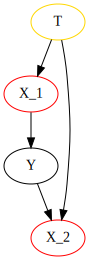

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## Idées Clés

Dans cette section, nous avons examiné les variables qui ne sont pas des variables de confusion et si nous devrions les ajouter ou non à notre modèle pour l'identification causale. Nous avons vu que les variables qui sont de bons prédicteurs du résultat $y$ devraient être ajoutées au modèle même si elles ne prédisent pas $T$ (ne sont pas des variables de confusion). Cela s'explique par le fait que prédire $Y$ réduit sa variance et augmente la probabilité de trouver des résultats statistiquement significatifs lors de l'estimation de l'effet causal. Ensuite, nous avons vu qu'il est une mauvaise idée d'ajouter des variables qui prédisent le traitement mais pas le résultat. Ces variables réduisent la variabilité du traitement, rendant plus difficile la détection de l'effet causal. Enfin, nous avons abordé le biais de sélection. C'est un biais qui survient lorsque nous contrôlons des variables dans le chemin causal du traitement au résultat ou des variables qui sont des effets communs du traitement et du résultat.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).